In [8]:
!pip install torchaudio==2.0.2

ERROR: Could not find a version that satisfies the requirement torchaudio==2.0.2 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0)

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for torchaudio==2.0.2


In [6]:
!pip install speechbrain torch torchaudio


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [7]:
import torch
from speechbrain.processing.features import LFCC
import torchaudio

# Load audio
signal, sr = torchaudio.load("/Users/rohitlabade/Desktop/SAMSUNG-LID-MARATHI/spoofed/1.m4a")

# Initialize LFCC extractor
lfcc_extractor = LFCC(
    sample_rate=sr,
    n_fft=512,
    n_mels=0,         # not using mel scale
    n_lin=60,         # number of linear filters
    n_ceps=20,        # number of LFCC coefficients
    hop_length=160,   # 10 ms stride if sr=16k
    win_length=400,   # 25 ms window if sr=16k
    log_mel=True,
    use_energy=False,
)

# Compute LFCCs
lfcc = lfcc_extractor(signal)

print("LFCC shape:", lfcc.shape)  # (batch, frames, coefficients)

AttributeError: module 'torchaudio' has no attribute 'list_audio_backends'

In [1]:
import torchaudio
import torchaudio.functional as F
import torch

waveform, sr = torchaudio.load("spoofed/1.m4a")  # should now work fine

lfcc = F.lfcc(
    waveform,
    sample_rate=sr,
    n_filter=60,
    n_lfcc=20,
    log_lf=True,
    speckwargs={"n_fft": 512, "hop_length": 160, "win_length": 400}
)

print("LFCC shape:", lfcc.shape)

RuntimeError: Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6 and 7.
          2. The PyTorch version (2.9.0) is not compatible with
             this version of TorchCodec. Refer to the version compatibility
             table:
             https://github.com/pytorch/torchcodec?tab=readme-ov-file#installing-torchcodec.
          3. Another runtime dependency; see exceptions below.
        The following exceptions were raised as we tried to load libtorchcodec:
        
[start of libtorchcodec loading traceback]
FFmpeg version 7: Could not load this library: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchcodec/libtorchcodec_core7.dylib
FFmpeg version 6: Could not load this library: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchcodec/libtorchcodec_core6.dylib
FFmpeg version 5: Could not load this library: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchcodec/libtorchcodec_core5.dylib
FFmpeg version 4: Could not load this library: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchcodec/libtorchcodec_core4.dylib
[end of libtorchcodec loading traceback].

In [2]:
import torchaudio
torchaudio.set_audio_backend("sox_io")

waveform, sr = torchaudio.load("spoofed/1.m4a")
print(sr, waveform.shape)

AttributeError: module 'torchaudio' has no attribute 'set_audio_backend'

LFCC shape: (20, 743)


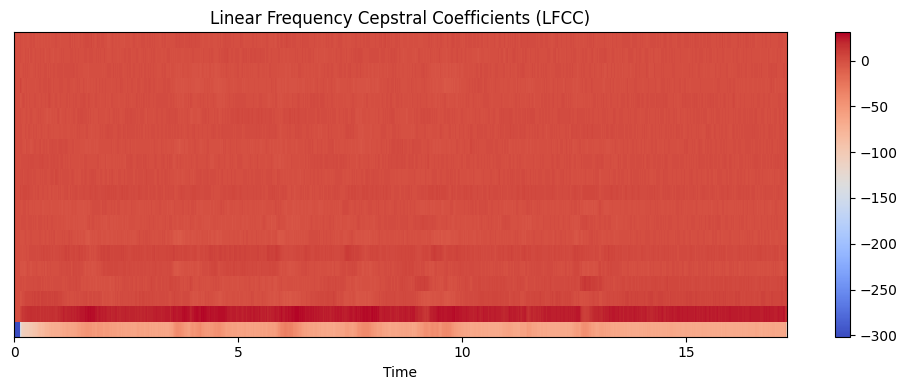

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def lfcc(y, sr, n_fft=512, n_filter=70, n_lfcc=20, hop_length=160, win_length=400):
    """
    Compute LFCC (Linear Frequency Cepstral Coefficients) using Librosa.
    """
    # Step 1: Compute power spectrum
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2

    # Step 2: Create linearly spaced filter banks
    # Unlike MFCC, we use linear spacing
    linear_fb = librosa.filters.mel(
        sr=sr,
        n_fft=n_fft,
        n_mels=n_filter,
        fmin=0,
        fmax=sr / 2,
        htk=True,
        norm=None,
    )

    freqs = np.linspace(0, sr/2, n_filter+2)
    filters = np.zeros((n_filter, int(1 + n_fft//2)))
    for i in range(1, n_filter + 1):
        f_m_minus = freqs[i - 1]
        f_m = freqs[i]
        f_m_plus = freqs[i + 1]
        for k in range(int(1 + n_fft//2)):
            f = (sr/2) * k / (n_fft//2)
            if f_m_minus <= f <= f_m:
                filters[i-1, k] = (f - f_m_minus) / (f_m - f_m_minus)
            elif f_m <= f <= f_m_plus:
                filters[i-1, k] = (f_m_plus - f) / (f_m_plus - f_m)
    # Step 3: Apply filters to power spectrum
    spec = np.dot(filters, S)

    # Step 4: Log-compress
    spec = np.where(spec == 0, np.finfo(float).eps, spec)
    log_spec = np.log(spec)

    # Step 5: DCT to get cepstral coefficients
    lfccs = librosa.feature.mfcc(S=log_spec, n_mfcc=n_lfcc, dct_type=2)
    return lfccs

# Example usage
audio_path = "/Users/rohitlabade/Desktop/SAMSUNG-LID-MARATHI/aasist/datasets/LA/ASVspoof2019_LA_train/flac/output1.wav"
y, sr = librosa.load(audio_path, sr=16000)

lfccs = lfcc(y, sr)
print("LFCC shape:", lfccs.shape)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(lfccs, x_axis="time")
plt.colorbar()
plt.title("Linear Frequency Cepstral Coefficients (LFCC)")
plt.tight_layout()
plt.show()

LFCC shape: (20, 743)


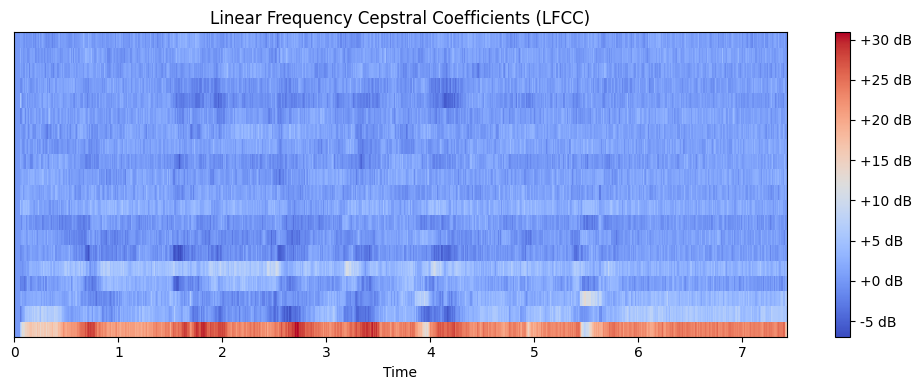

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fftpack import dct

def lfcc_extractor(y, sr, n_fft=512, n_filter=70, n_lfcc=20, hop_length=160, win_length=400):
  
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2
    freq_bins = np.linspace(0, sr/2, int(1 + n_fft/2))

    f_min, f_max = 0, sr/2
    filter_edges = np.linspace(f_min, f_max, n_filter + 2)
    fbanks = np.zeros((n_filter, len(freq_bins)))

    for i in range(1, n_filter + 1):
        left, center, right = filter_edges[i-1:i+2]
        fbanks[i-1] = np.maximum(0, np.minimum((freq_bins - left)/(center - left), (right - freq_bins)/(right - center)))

    spec = np.dot(fbanks, S)
    spec = np.where(spec == 0, np.finfo(float).eps, spec)

    log_spec = np.log(spec)

   
    lfcc = dct(log_spec, type=2, axis=0, norm='ortho')[1 : (n_lfcc + 1)]
    return lfcc

# Load example
y, sr = librosa.load("/Users/rohitlabade/Desktop/SAMSUNG-LID-MARATHI/aasist/datasets/LA/ASVspoof2019_LA_train/flac/output1.wav", sr=16000)
lfcc = lfcc_extractor(y, sr)

print("LFCC shape:", lfcc.shape)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(lfcc, x_axis='time', sr=sr, hop_length=160)
plt.colorbar(format='%+2.0f dB')
plt.title("Linear Frequency Cepstral Coefficients (LFCC)")
plt.tight_layout()
plt.show()

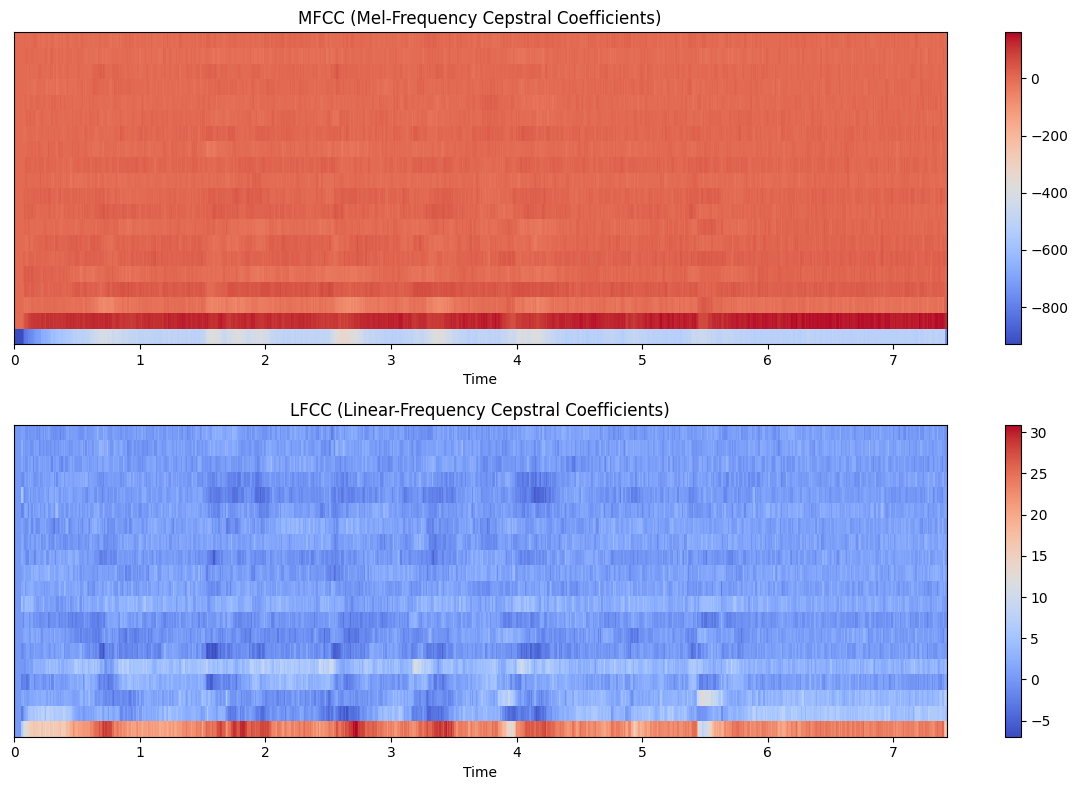

In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fftpack import dct

# ---- LFCC extractor ----
def lfcc_extractor(y, sr, n_fft=512, n_filter=70, n_lfcc=20, hop_length=160, win_length=400):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2
    freq_bins = np.linspace(0, sr/2, int(1 + n_fft/2))

    f_min, f_max = 0, sr/2
    filter_edges = np.linspace(f_min, f_max, n_filter + 2)
    fbanks = np.zeros((n_filter, len(freq_bins)))

    for i in range(1, n_filter + 1):
        left, center, right = filter_edges[i-1:i+2]
        fbanks[i-1] = np.maximum(0, np.minimum((freq_bins - left)/(center - left),
                                               (right - freq_bins)/(right - center)))

    spec = np.dot(fbanks, S)
    spec = np.where(spec == 0, np.finfo(float).eps, spec)
    log_spec = np.log(spec)
    lfcc = dct(log_spec, type=2, axis=0, norm='ortho')[1:(n_lfcc+1)]
    return lfcc

# ---- Load audio ----
y, sr = librosa.load("/Users/rohitlabade/Desktop/SAMSUNG-LID-MARATHI/aasist/datasets/LA/ASVspoof2019_LA_train/flac/output1.wav", sr=16000)

# ---- Extract MFCC ----
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=512, hop_length=160, win_length=400)

# ---- Extract LFCC ----
lfcc = lfcc_extractor(y, sr)

# ---- Plot comparison ----
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=160)
plt.colorbar()
plt.title("MFCC (Mel-Frequency Cepstral Coefficients)")

plt.subplot(2, 1, 2)
librosa.display.specshow(lfcc, x_axis='time', sr=sr, hop_length=160)
plt.colorbar()
plt.title("LFCC (Linear-Frequency Cepstral Coefficients)")

plt.tight_layout()
plt.show()